In [62]:
from functools import partial, reduce
import math

from affine import Affine
from geojson import loads
import h5py
import matplotlib.pyplot as plt
import numpy as np
from pyproj import CRS, Proj, transformimport pandas as pd
import rasterio.features as rfeat
import scipy
from shapely import ops
from shapely.geometry import shape

from hyperspectral.math import goodness_of_fit, project_data, rpca_grid, shrinkage_covariance
from hyperspectral.spectra import Spectrum, SpectralLibrary
from hyperspectral.target import normalized_matched_filter

In [100]:
with h5py.File('data/HSI/PRISMA/PRS_L2D_STD_20200825024857_20200825024901_0001.he5') as h5:
    λs = np.hstack([h5.attrs['List_Cw_Swir'], h5.attrs['List_Cw_Vnir']])
    flags = np.hstack([h5.attrs['List_Cw_Swir_Flags'], h5.attrs['List_Cw_Vnir_Flags']])
    ul = h5.attrs['Product_ULcorner_easting'], h5.attrs['Product_ULcorner_northing']
    lr = h5.attrs['Product_LRcorner_easting'], h5.attrs['Product_LRcorner_northing']
    epsg = h5.attrs['Epsg_Code']
    r,_,c = h5['HDFEOS']['SWATHS']['PRS_L2D_HCO']['Data Fields']['VNIR_Cube'].shape

In [112]:
band_freqs = sorted(
    zip(
        λs[flags==1], 
        map(lambda x: x[0], filter(lambda x: x[1]==1, enumerate(flags)))
    )
)

In [83]:
resx, resy = (lr[0] - ul[0])/c, (lr[1] - ul[1])/r

In [84]:
a = Affine(resx,0,ul[0],0,resy,ul[1])
a

Affine(29.97482202680067, 0.0, 267337.84375,
       0.0, -29.973706530958438, 9112332.0)

In [85]:
a * (c,r), lr

((303127.78125, 9076993.0), (303127.78, 9076993.0))

In [46]:
indo_crs = CRS.from_epsg(epsg)
lat_lng = CRS.from_epsg(4326)

In [56]:
def trans(long, lat):
    return transform(lat_lng, indo_crs, lat, long)

In [171]:
with open('data/bali_tpa_active.geojson') as gj:
    g = loads(gj.read())
    shapes = [shape(f['geometry']) for f in g['features']]
    tpa_active = ops.transform(trans, shapes[0])

In [186]:
with open('data/bali_tpa_site.geojson') as gj:
    g = loads(gj.read())
    shapes = [shape(f['geometry']) for f in g['features']]
    tpa_boundary = ops.transform(trans, shapes[0])

In [201]:
active_mask = rfeat.geometry_mask([tpa_active.buffer(0)], (r, c), a, invert=True)
dirty_mask = rfeat.geometry_mask([tpa_boundary.buffer(resx*10)], (r, c), a, invert=True)

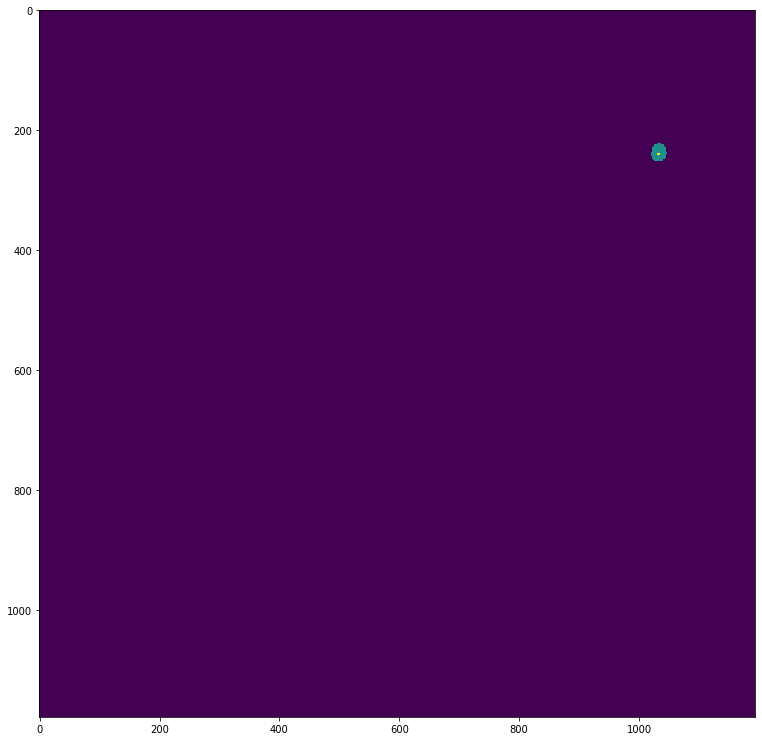

In [209]:
_, ax = plt.subplots(figsize=(13,13))
ax.imshow(np.add(active_mask.astype(int), dirty_mask.astype(int)),vmax = 2)

In [211]:
tpa_active.area, np.sum(active_mask), np.sum(dirty_mask)

(9070.650041419573, 12, 626)

In [213]:
def ecosis_row_to_spectrum(r, type_, class_):
    data = list(map(lambda kv: (int(kv[0]), kv[1]), filter(lambda kv: kv[0][0] in '0123456789', r.items())))
    metadata = {k:v for k,v in r.items() if k[0] not in '0123456789'}
    xs = list(map(lambda kv: kv[0], data))
    ys = list(map(lambda kv: kv[1], data))
    if 'wavelengths' in metadata.keys():
        metadata['X Units'] = metadata['wavelengths']
    if 'column_units' in metadata.keys():
        metadata['Y Units'] = metadata['column_units']
    return Spectrum(metadata['description'], type_, class_, min(xs), max(xs), len(xs), metadata, xs, ys)

In [214]:
marine = pd.read_csv('data/spectral-reflectance-of-dry-and-wet-marine-harvested-microplastics-from-kamilo-point--pacific-ocean.csv')
mean_plastic = ecosis_row_to_spectrum(marine.iloc[4], 'manmade', 'plastic')
reference_spectra = SpectralLibrary([mean_plastic])
reference_spectra.regularize([bf[0] for bf in band_freqs], source_bands=[bf[1] for bf in band_freqs])

In [215]:
with h5py.File('data/HSI/PRISMA/PRS_L2D_STD_20200825024857_20200825024901_0001.he5') as h5:
    data = h5['HDFEOS']['SWATHS']['PRS_L2D_HCO']['Data Fields']
    swir_error = np.swapaxes(data['SWIR_PIXEL_L2_ERR_MATRIX'], 1, 2)
    vnir_error = np.swapaxes(data['VNIR_PIXEL_L2_ERR_MATRIX'], 1, 2)
    swir = np.swapaxes(data['SWIR_Cube'], 1, 2)
    vnir = np.swapaxes(data['VNIR_Cube'], 1, 2)
    raw = np.dstack([swir, vnir])/65535

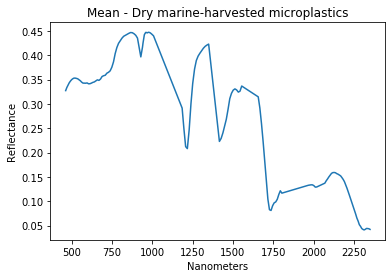

In [216]:
bad_bands = np.arange(raw.shape[2],dtype=int)[np.sum(raw[600:800,600,:], axis=0)<2]

to_drop = list(reference_spectra.invalid_bands().union(set(bad_bands)))
reference_spectra.drop_bands(to_drop)
reference_spectra.spectra[0].plot()

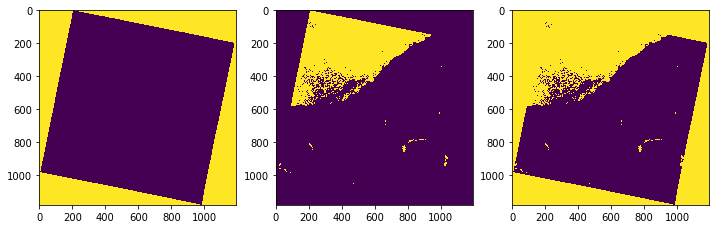

In [217]:
nodata_mask = np.sum(swir, axis=2) == 0.0
error_mask = np.sum(np.dstack([swir_error, vnir_error]) == 2, axis=2)>40
mask = error_mask + nodata_mask

_, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(nodata_mask)
axs[1].imshow(error_mask)
axs[2].imshow(mask)

In [218]:
freqs = np.array(reference_spectra.spectra[0].x)
ix = np.linspace(0,len(freqs)-1,num=len(freqs))
rband = np.argmin(np.abs(freqs - 650))
gband = np.argmin(np.abs(freqs - 550))
bband = np.argmin(np.abs(freqs - 450))

In [219]:
aoi = raw[:,:,reference_spectra.source_bands]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


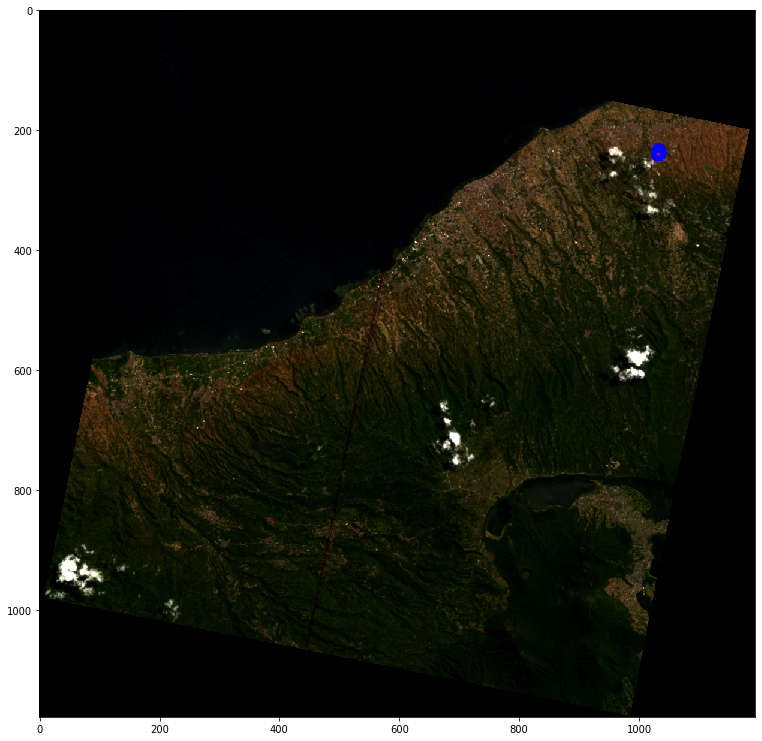

In [221]:
rgb = aoi[:,:,[rband,gband,bband]]
(rgb[:,:,0].view())[dirty_mask] = 0.0
(rgb[:,:,1].view())[dirty_mask] = 0.0
(rgb[:,:,2].view())[dirty_mask] = 1.0
(rgb[:,:,0].view())[active_mask] = 1.0
(rgb[:,:,1].view())[active_mask] = 0.0
(rgb[:,:,2].view())[active_mask] = 0.0
_, ax = plt.subplots(figsize=(13,13))
ax.imshow(rgb * 3)

In [222]:
buffer = tpa_boundary.buffer(resx*40)
buffer_mask = rfeat.geometry_mask([buffer], (r, c), a, invert=True)
c_range = np.arange(c)[np.max(buffer_mask, axis=0)==1]
r_range = np.arange(r)[np.max(buffer_mask, axis=1)==1]
(c0, c1) = c_range[0], c_range[-1]
(r0, r1) = r_range[0], r_range[-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


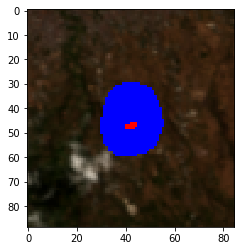

In [223]:
plt.imshow(rgb[r0:r1,c0:c1,:] * 2)

In [224]:
extract = aoi[r0:r1,c0:c1,:]
active_extract = active_mask[r0:r1,c0:c1]
dirty_extract = dirty_mask[r0:r1,c0:c1]

In [225]:
np.savez("data/tpa_extract.npz", extract=extract, active=active_extract, dirty=dirty_extract)